In [3]:
#import importlib
#import debugsudoku
#importlib.reload(debugsudoku)
#print(debugsudoku.d_model)
%run debugsudoku.py
print(d_model)


9


In [4]:
print("--- Training with AdamW Optimizer (float32) ---")
torch.set_default_dtype(dtype_float32) # Set default dtype for this block
# 3. Generate training and validation data for AdamW
X_train_oh_adamw, y_train_adamw, X_val_oh_adamw, y_val_adamw, X_train_original_adamw, X_val_original_adamw = generate_data(num_symbols=9, train_frac=0.003, seed=42, dtype=dtype_float32)

# 4. Initialize a new model and loss function
model_adamw, loss_fn_adamw = initialize_model_and_loss(d_model, seq_len, dtype=dtype_float32)

# 5. Initialize an AdamW optimizer
optimizer_adamw = optim.AdamW(model_adamw.parameters(), lr=0.03)

# 6. Train the model using train_model with AdamW optimizer
adamw_loss_history = train_model(model_adamw, optimizer_adamw, loss_fn_adamw, X_train_oh_adamw, y_train_adamw,
                                 epochs=500, log_interval=100, optimizer_type='adamw')

--- Training with AdamW Optimizer (float32) ---
Train OH: torch.Size([2177, 9, 9]) Train y: torch.Size([2177, 1])
Val OH:   torch.Size([723583, 9, 9]) Val y: torch.Size([723583, 1])
Epoch    0 | Loss: 0.68294746 | Acc: 0.50987598
Epoch  100 | Loss: 0.06874266 | Acc: 0.94625632
Epoch  200 | Loss: 0.06179720 | Acc: 0.95406523
Epoch  300 | Loss: 0.06079365 | Acc: 0.95452458
Epoch  400 | Loss: 0.05980705 | Acc: 0.95130914


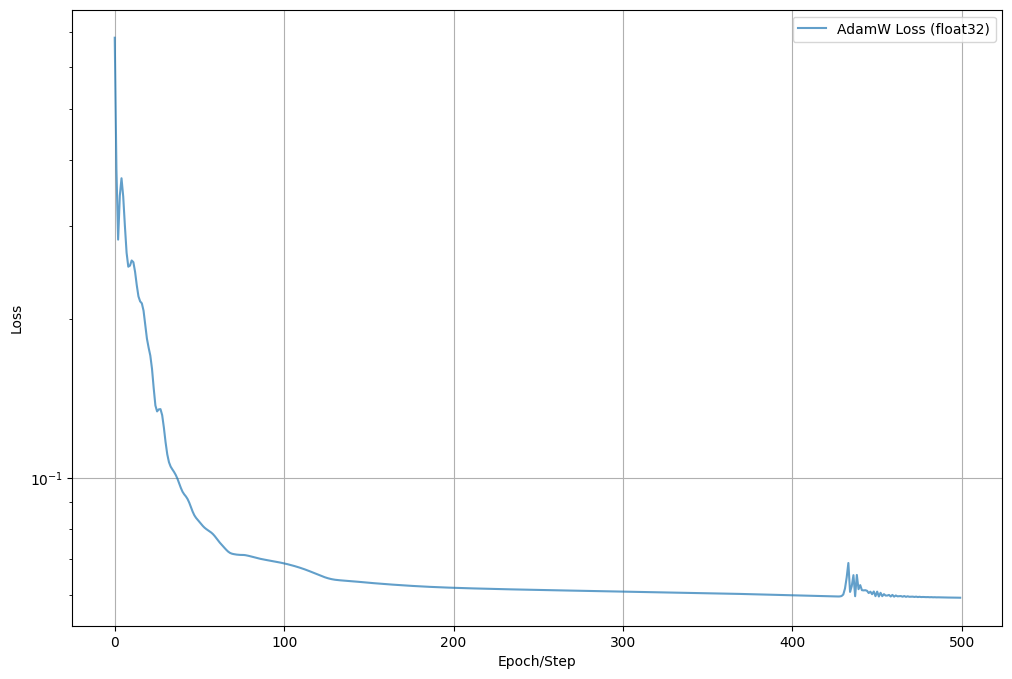

In [6]:
# --- Visualize Training History ---
plt.figure(figsize=(12, 8))
plt.plot(adamw_loss_history, label='AdamW Loss (float32)', alpha=0.7)
# plt.plot(lbfgs_loss_history, label='LBFGS Loss (float64)', alpha=0.7)
# plt.plot(custom_loss_history, label='Custom Update Loss (float32)', alpha=0.7)
# plt.plot(small_data_loss_history, label='AdamW (5 Symbols, float32) Loss', alpha=0.7, linestyle='--')
plt.xlabel('Epoch/Step')
plt.ylabel('Loss')
#plt.title('Training Loss History for Different Optimizers and Data Parameters')
plt.legend()
plt.grid(True)
plt.yscale('log') # Use log scale for better visualization of different convergence speeds
plt.show()